In [1]:
import netCDF4
from netCDF4 import Dataset
import os
from os.path import dirname
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib 
import matplotlib.pyplot as plt
from math import pi
from numpy import cos,sin
from scipy.spatial import cKDTree
from numpy import absolute as abs
import numpy.ma as ma
import sys
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output

In [13]:
# Choose folder and resolution
folder = dirname(dirname(os.getcwd())) + '\\Data_WQ\\' #The folder where the datasets are
resolution = '110m' # Change border resolution for the maps. Insert value in meters (e.g. '100m')

In [10]:
## Open dataset and store variables in var_values dictionary. Units are in var_units dictionary. Names in var_names
'''
Datasets:
    1: CHL-model
    2: CHL-satellite
    3: DOXYL-model
    4: NITR-model
    5: PHOS-model
    6: SPM-satellite
'''


def select_dataset(num_dataset):
    # Define global variables
    global var_values, var_units, var_names, selected_variable, text
    
    # Open dataset
    if num_dataset == 2:
        file = folder + "dataset-CHL-satellite-daily.nc"
        selected_variable = 'CHL'
        text = 'Mass concentration of chlorophyll-a in sea water - satellite'
    elif num_dataset == 3:
        file = folder + "dataset-DOXYL-model-daily.nc"
        selected_variable = 'o2'
        text = 'Mole concentration of dissolved molecular oxygen in sea water - model'
    elif num_dataset == 4:
        file = folder + "dataset-NITR-model-daily.nc"
        selected_variable = 'no3'
        text = 'Mole concentration of nitrate in sea water - model'
    elif num_dataset == 5:
        file = folder + "dataset-PHOS-model-daily.nc"
        selected_variable = 'po4'
        text = 'Mole concentration of phosphate in sea water - model'
    elif num_dataset == 6:
        file = folder + "dataset-SPM-satellite-monthly.nc"
        selected_variable = 'SPM'
        text = 'Mass concentration of inorganic suspended matter in sea water - satellite'
    else:
        file = folder + "dataset-CHL-model-daily.nc"
        selected_variable = 'chl'
        text = 'Mass concentration of chlorophyll-a in sea water - model'

    dataset = Dataset(file, "r")
    print('Using dataset {}'.format(file))


    var_values = {}
    var_units = {}
    var_names = {}

    for k in dataset.variables.keys():
        # Standardize keys 'latitude' and 'longitude'
        if k == 'lat':
            k_new = 'latitude'
        elif k == 'lon':
            k_new = 'longitude'
        else:
            k_new = k

        var_units[k_new] = dataset.variables[k].units # Save units
        var_names[k_new] = dataset.variables[k].long_name # Save name
        if 'time' in var_names[k_new]: #Save time
            var_values[k_new] = netCDF4.num2date(dataset.variables[k][:],var_units[k_new], only_use_cftime_datetimes=False, only_use_python_datetimes = True)
        else:
            var_values[k_new] = dataset.variables[k][:]

        # Remove single-dimensional entries
        var_values[k_new] = np.squeeze(var_values[k_new])

    # Close dataset
    dataset.close()

In [3]:
## Plot
def plot_map(timestep):
    if timestep > var_values['time'].size-1:
        print('The timestep selected does not exist')
        return
    # Take values of variable at timestep
    var_plot = var_values[selected_variable][timestep,:,:]

    # Initialize plot
    matplotlib.rcParams['figure.figsize'] = (10,10) 

    # Initialize map
    proj=ccrs.Mercator()
    m = plt.axes(projection=proj)

    # Format map
    m.stock_img()
    m.coastlines(resolution=resolution)
    m.add_feature(cfeature.BORDERS)
    gl=m.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabels_top = False
    gl.ylabels_right = False

    # Plot data
    plt.contourf(var_values['longitude'], var_values['latitude'], var_plot, 60,
                 transform=ccrs.PlateCarree())

    # Add Colorbar
    cbar = plt.colorbar()
    cbar.set_label(var_units[selected_variable])

    # Add Title
    plt.title(text)
    plt.show()

In [11]:
def timestep2date(timestep):
    print('The date corresponding to that timestep is ' + var_values['time'][timestep].strftime("%d-%m-%Y %H:%M:%S"))

In [12]:
def on_button_clicked(b):
    clear_output(wait=True)
    display(button)
    plot_map(timestep_slider.value)

In [6]:
print('Choose dataset')
interact_manual(select_dataset, num_dataset=[('Chlorophyll-model', 1), ('Chlorophyll-satellite', 2), ('Oxygen-model', 3), ('Nitrate-model', 4), ('Phosphate-model', 5), ('Suspended matter-satellite', 6)])

Choose dataset


interactive(children=(Dropdown(description='num_dataset', options=(('Chlorophyll-model', 1), ('Chlorophyll-sat…

<function __main__.select_dataset(num_dataset)>

In [7]:
print('Check timestep-date correspondence')
timestep_slider = widgets.IntSlider(value = 0, min = 0, max = var_values['time'].size-1, description='Timestep')
button = widgets.Button(description="Plot")
interact(timestep2date,timestep = timestep_slider)

Check timestep-date correspondence


interactive(children=(IntSlider(value=0, description='Timestep', max=7668), Output()), _dom_classes=('widget-i…

<function __main__.timestep2date(timestep)>

Button(description='Plot', style=ButtonStyle())

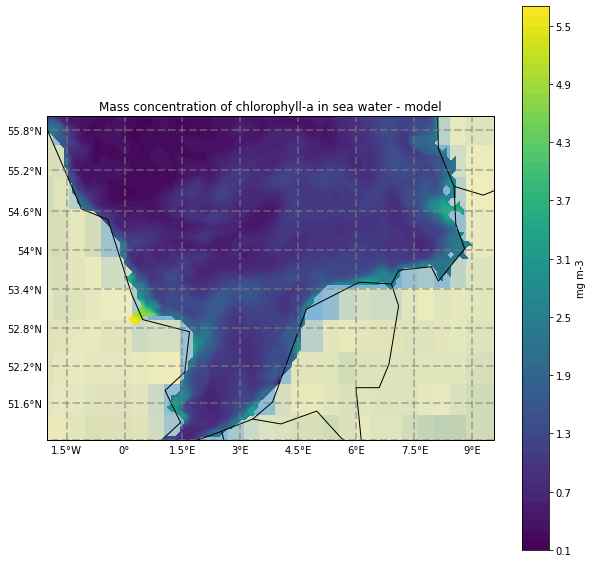

In [14]:
display(button)
button.on_click(on_button_clicked)